<img src="http://akhavanpour.ir/notebook/images/srttu.gif" alt="SRTTU" style="width: 150px;"/>

[![Azure Notebooks](https://notebooks.azure.com/launch.png)](https://notebooks.azure.com/import/gh/Alireza-Akhavan/class.vision)

In [1]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense


Using TensorFlow backend.


In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

dataset = 'E:/dataset/multi-label/dataset'

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)
random.shuffle(imagePaths)

# initialize the data and labels
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (96, 96))
	image = img_to_array(image)
	data.append(image)

	# extract set of class labels from the image path and update the
	# labels list
	l = label = imagePath.split(os.path.sep)[-2].split("_")
	labels.append(l)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))
labels

[INFO] loading images...
[INFO] data matrix: 1369 images (295.70MB)


array([['blue', 'shirt'],
       ['blue', 'jeans'],
       ['blue', 'shirt'],
       ..., 
       ['black', 'jeans'],
       ['black', 'jeans'],
       ['red', 'shirt']],
      dtype='<U5')

In [3]:
labels

array([['blue', 'shirt'],
       ['blue', 'jeans'],
       ['blue', 'shirt'],
       ..., 
       ['black', 'jeans'],
       ['black', 'jeans'],
       ['red', 'shirt']],
      dtype='<U5')

In [4]:
# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))


[INFO] class labels:
1. black
2. blue
3. jeans
4. red
5. shirt


In [5]:
labels

array([[0, 1, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 0, 1],
       ..., 
       [1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1]])

In [6]:
mlb.classes_

array(['black', 'blue', 'jeans', 'red', 'shirt'], dtype=object)

In [7]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [9]:
classes = len(mlb.classes_)
classes

5

In [10]:
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
model = Sequential()
# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(96,96,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(classes))
model.add(Activation("sigmoid"))


In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [12]:
# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
 
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/50
34/34 [==============================] - 105s 3s/step - loss: 0.2917 - acc: 0.8823 - val_loss: 0.4729 - val_acc: 0.8993
Epoch 2/50
34/34 [==============================] - 106s 3s/step - loss: 0.1454 - acc: 0.9484 - val_loss: 0.3940 - val_acc: 0.9197
Epoch 3/50
34/34 [==============================] - 110s 3s/step - loss: 0.1120 - acc: 0.9603 - val_loss: 0.3777 - val_acc: 0.9263
Epoch 4/50
34/34 [==============================] - 123s 4s/step - loss: 0.0851 - acc: 0.9711 - val_loss: 0.3353 - val_acc: 0.9255
Epoch 5/50
34/34 [==============================] - 112s 3s/step - loss: 0.0658 - acc: 0.9768 - val_loss: 0.1084 - val_acc: 0.9701
Epoch 6/50
34/34 [==============================] - 109s 3s/step - loss: 0.0852 - acc: 0.9711 - val_loss: 0.1977 - val_acc: 0.9445
Epoch 7/50
34/34 [==============================] - 107s 3s/step - loss: 0.1331 - acc: 0.9583 - val_loss: 0.2088 - val_acc: 0.9445
Epoch 8/50
34/34 [==============================] - 108s

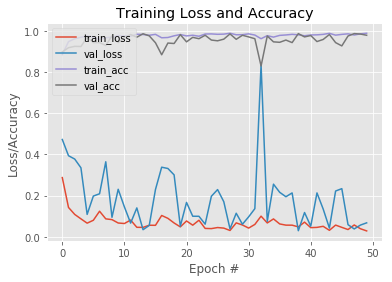

In [15]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [16]:
# save the model to disk
model.save("ml_fashion.h5")
 
# save the multi-label binarizer to disk
f = open('ml_fashion.pickle', "wb")
f.write(pickle.dumps(mlb))
f.close()

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دانشگاه تربیت دبیر شهید رجایی<br>مباحث ویژه 2 - یادگیری عمیق پیشرفته<br>علیرضا اخوان پور<br>97-98<br>
</div>
<a href="https://www.srttu.edu/">SRTTU.edu</a> - <a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a>
</div>